<a href="https://colab.research.google.com/github/mocedon/CVHW/blob/master/hw2_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from google.colab import files

# uploaded = files.upload()

# import io

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""
This generic helping side code provides convenient functions and classes to
    every other module's "Run As A Script" section.
"""

###############################################################################
# -----------------------------------------------------------------------------
# Imports
# -----------------------------------------------------------------------------
###############################################################################
import pathlib
import numpy as np
import scipy.io


###############################################################################
# -----------------------------------------------------------------------------
# Classes
# -----------------------------------------------------------------------------
###############################################################################
class RunAsScriptStore(object):
    """
    A class for storing Run-As-Script-defined variables while maintaining
        a clean namespace.
    It provides easy savemat and loadmat operations to all self's attributes.
    """
    def savemat(self, file_name, mdict=None, appendmat=True, **kwargs):
        """
        Call scipy.io.savemat on RunAsScript attributes.
        ------------------------------------------------------------------------
        DESCRIPTION COPIED FROM scipy.io.savemat !
        Parameters
        ----------
        file_name : str or file-like object
            Name of the .mat file (.mat extension not needed if ``appendmat ==
            True``).
            Can also pass open file_like object.
        mdict : dict
            Dictionary from which to save matfile variables.
        appendmat : bool, optional
            True (the default) to append the .mat extension to the end of the
            given filename, if not already present.
        kwargs : dict
           Other keyword arguments of scipy.io.savemat.
        """
        # Set mdict default value to empty dictionary
        if mdict is None:
            mdict = {}

        # Merge mdict with attributes dictionary, giving mdict the upper-hand
        #   in case of inconsistency
        dsavemat = {**vars(self), **mdict}

        # Save the merged dictionary to a .mat file
        scipy.io.savemat(file_name, dsavemat, appendmat, **kwargs)

    def loadmat(self, file_name, mdict=None, appendmat=True, **kwargs):
        """
        Call scipy.io.loadmat into RunAsScript attributes.
        ------------------------------------------------------------------------
        DESCRIPTION COPIED FROM scipy.io.loadmat !
        Parameters
        ----------
        file_name : str
           Name of the mat file (do not need .mat extension if
           appendmat==True). Can also pass open file-like object.
        mdict : dict, optional
            Dictionary in which to insert matfile variables.
        appendmat : bool, optional
           True to append the .mat extension to the end of the given
           filename, if not already present.
        kwargs : dict
           Other keyword arguments of scipy.io.loadmat.
        Returns
        -------
        mat_dict : dict
           dictionary with variable names as keys, and loaded matrices as
           values.
        Notes
        -----
        v4 (Level 1.0), v6 and v7 to 7.2 matfiles are supported.
        You will need an HDF5 python library to read MATLAB 7.3 format mat
        files.  Because scipy does not supply one, we do not implement the
        HDF5 / 7.3 interface here.
        """
        # Merge mdict with attributes dictionary, giving mdict the upper-hand
        #   in case of inconsistency
        dloadmat = scipy.io.loadmat(file_name, mdict, appendmat, **kwargs)

        # Squeeze all 2d results to their true dimension
        dloadmat = {key: np.squeeze(value) for key, value in dloadmat.items()}

        # Pour the dictionary from the .mat file into the objects fields
        self.__dict__.update(dloadmat)

        return dloadmat


###############################################################################
# -----------------------------------------------------------------------------
# Functions
# -----------------------------------------------------------------------------
###############################################################################
# # # # # # # # # # # # # # File management functions # # # # # # # # # # # # #
def list_files_in_subfolders(fpath, pattern=r"*"):
    """List all files in folder and sub-folders that match a given pattern"""
    return tuple(pathlib.Path(fpath).rglob(pattern))


In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""
This code is the Visualizing CNN Filters segment from the tutorial appendix,
with minor changes.
"""

###############################################################################
# -----------------------------------------------------------------------------
# Imports
# -----------------------------------------------------------------------------
###############################################################################
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

###############################################################################
# -----------------------------------------------------------------------------
# Constants
# -----------------------------------------------------------------------------
###############################################################################
# Files and paths constants
ROOT_FOLDER = pathlib.Path(r"/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code")
OUTPUT_FOLDER = ROOT_FOLDER / pathlib.Path(r"output\Part2")


###############################################################################
# -----------------------------------------------------------------------------
# Functions
# -----------------------------------------------------------------------------
###############################################################################
def plot_filters_single_channel_big(t):
    # setting the rows and columns
    nrows = t.shape[0] * t.shape[2]
    ncols = t.shape[1] * t.shape[3]

    npimg = np.array(t.cpu().numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)

    npimg = npimg.T

    fig, ax = plt.subplots(figsize=(ncols / 10, nrows / 200))
    #     fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

    return fig


def plot_filters_single_channel(t):
    # kernels depth * number of kernels
    nplots = t.shape[0] * t.shape[1]
    ncols = 12

    nrows = 1 + nplots // ncols

    count = 0
    fig = plt.figure(figsize=(ncols, nrows))

    # looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].cpu().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.tight_layout()

    return fig


def plot_filters_multi_channel(t):
    # get the number of kernals
    num_kernels = t.shape[0]

    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels

    # set the figure size
    fig = plt.figure(figsize=(num_cols, num_rows))

    # looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)

        # for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].cpu().numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    #     plt.savefig('myimage.png', dpi=100)
    plt.tight_layout()

    return fig


def plot_weights(model, layer_num, single_channel=True, collated=False, outname=None, n_filters=None):
    # extracting the model features at the particular layer number
    layer = model.features[layer_num]

    fig = None
    # checking whether the layer is convolution layer or not
    if isinstance(layer, nn.Conv2d):
        # getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data[slice(n_filters)]

        if single_channel:
            if collated:
                fig = plot_filters_single_channel_big(weight_tensor)
            else:
                fig = plot_filters_single_channel(weight_tensor)
            return fig
        else:
            if weight_tensor.shape[1] == 3:
                fig = plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")

    # Save figure if desired
    try:
        fig.savefig((OUTPUT_FOLDER / outname).with_suffix(".png"),
                    bbox_inches="tight", pad_inches=0)
    except (UnboundLocalError, TypeError):
        print("Figure not saved")

    return fig


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""
This code is the Visualizing Layer Output segment from the tutorial appendix
"""

###############################################################################
# -----------------------------------------------------------------------------
# Imports
# -----------------------------------------------------------------------------
###############################################################################
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

###############################################################################
# -----------------------------------------------------------------------------
# Constants
# -----------------------------------------------------------------------------
###############################################################################
# Files and paths constants
ROOT_FOLDER = pathlib.Path(r"/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code")
OUTPUT_FOLDER = ROOT_FOLDER / pathlib.Path(r"output\Part2")


###############################################################################
# -----------------------------------------------------------------------------
# Functions
# -----------------------------------------------------------------------------
###############################################################################
def to_grayscale(image):
    """
    input_ is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image


def normalize(image, device=torch.device("cpu")):
    _normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        _normalize
    ])
    image = preprocess(image).unsqueeze(0).to(device)
    return image


def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return str(index.item())


def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)


def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image


def fc_layer_outputs(input_, model, layer_to_output):
    input_ = model.features(input_)
    input_ = model.avgpool(input_)
    input_ = input_.view(1, -1)

    modulelist = list(model.classifier.modules())
    output = None
    for count, layer in enumerate(modulelist[1:]):
        input_ = layer(input_)
        if count == layer_to_output:
            output = input_

    return output


def filter_outputs(image, model, layer_to_visualize, n_filters=None, outname=None):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize:
            output = image

    filters = []
    output = output.data.squeeze().data[slice(n_filters)].cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i, :, :])

    fig = plt.figure(figsize=(10, 10))

    n = int(np.ceil(np.sqrt(len(filters))))
    m = len(filters) // n

    for i in range(len(filters)):
        ax = fig.add_subplot(m + 1, n, i + 1)
        ax.imshow(filters[i])
        ax.set_axis_off()
        # ax.set_title(i)
    plt.tight_layout()

    # Save figure if desired
    try:
        fig.savefig((OUTPUT_FOLDER / outname).with_suffix(".png"),
                    bbox_inches="tight", pad_inches=0)
    except (UnboundLocalError, TypeError, AttributeError):
        print("Figure not saved")


cuda:0


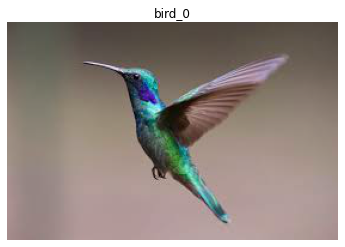

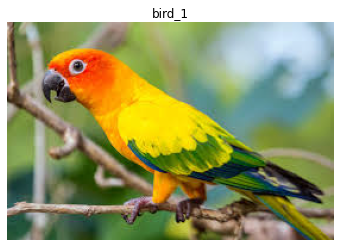

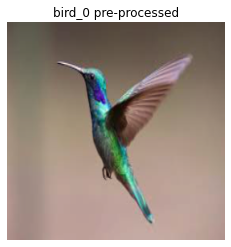

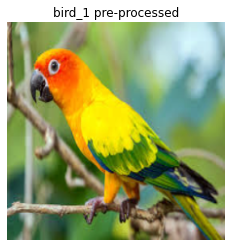

/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/birds/bird_0.jpg --> (94, 'hummingbird')
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/birds/bird_1.jpg --> (90, 'lorikeet')


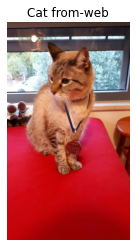

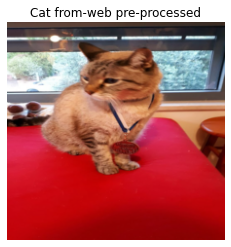

Cat from-web --> (281, 'tabby, tabby cat')


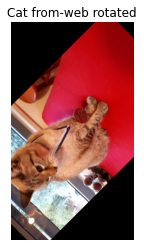

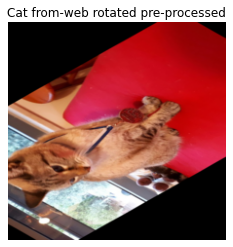

Cat from-web rotated --> (674, 'mousetrap')


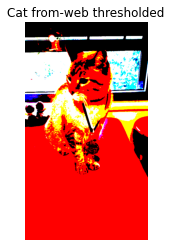

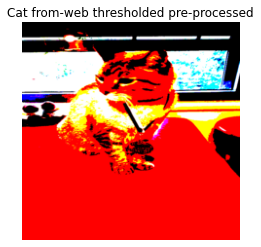

Cat from-web thresholded --> (851, 'television, television system')


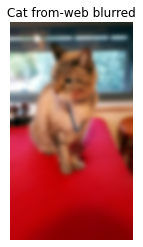

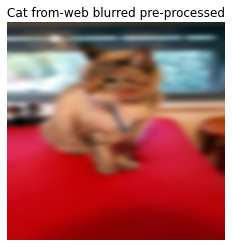

Cat from-web blurred --> (851, 'television, television system')
FC layer 1 has feature space of size torch.Size([1, 4096])
Groundtruth: [0 0 1 1]
Prediction: [0 0 1 1]
Success ratio over training set:  100.000000%
All Done!


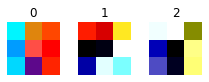

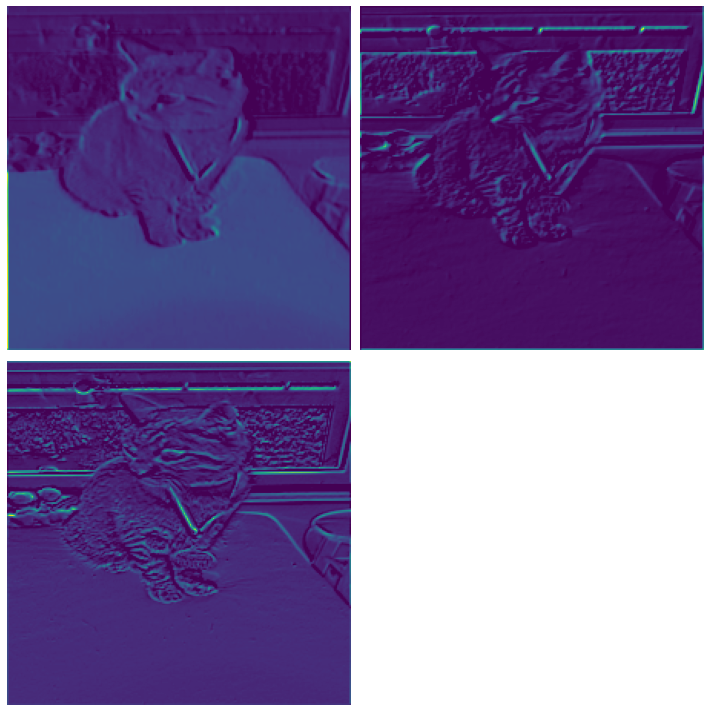

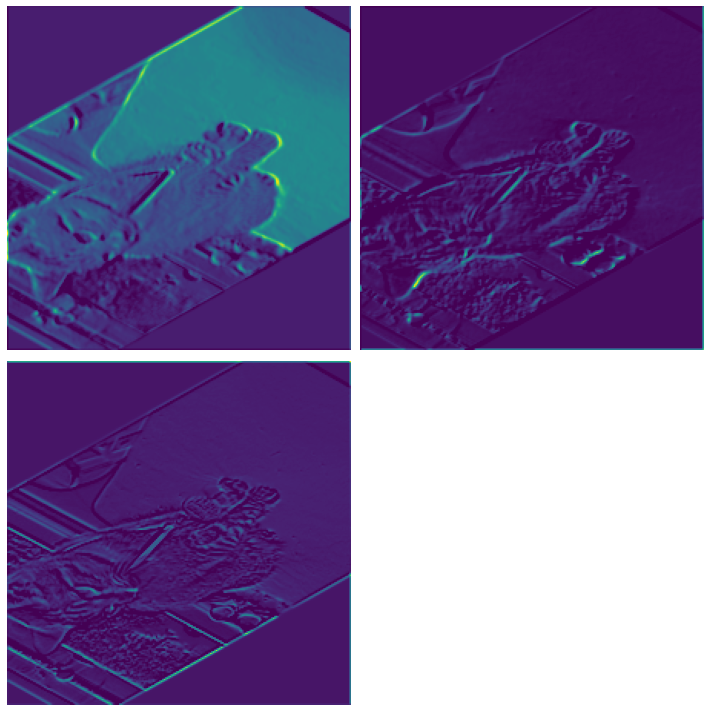

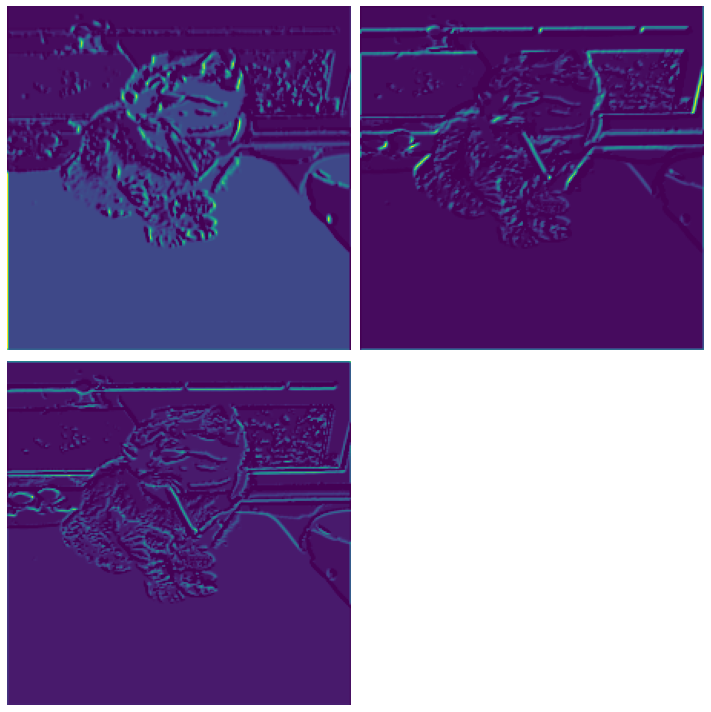

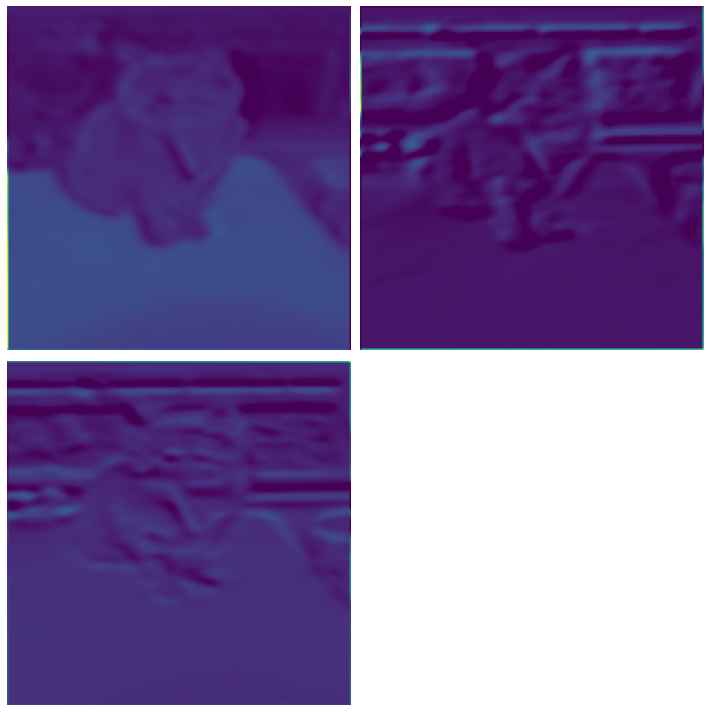

In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""
This code analyzes a pre-trained CNN (the VGG16) and utilizes it to classify
cat and dog images via Transfer Learning (TL).
"""

###############################################################################
# -----------------------------------------------------------------------------
# Imports
# -----------------------------------------------------------------------------
###############################################################################
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import skimage
from sklearn.svm import LinearSVC
import torch
import torchvision.models as models
import torchvision.transforms as transforms

################################################################################
# ------------------------------------------------------------------------------
# Constants
# ------------------------------------------------------------------------------
################################################################################
# Files and paths constants
ROOT_FOLDER = pathlib.Path(r"/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code")
CODE_FOLDER = ROOT_FOLDER / pathlib.Path(r"")
BIRDS_FOLDER = ROOT_FOLDER / pathlib.Path(r"birds")
CATS_FOLDER = ROOT_FOLDER / pathlib.Path(r"cats")
DOGS_FOLDER = ROOT_FOLDER / pathlib.Path(r"dogs")
MYDATA_FOLDER = ROOT_FOLDER / pathlib.Path(r"my_data")
OUTPUT_FOLDER = ROOT_FOLDER / pathlib.Path(r"output/part2")

# ImageNet-1000 class dictionary
with open(CODE_FOLDER / "ImageNet_Classes.txt") as _:
    CLASS = eval(_.read())

# Our class dictionary
CAT = 0
DOG = 1

###############################################################################
# -----------------------------------------------------------------------------
# Classes
# -----------------------------------------------------------------------------
###############################################################################


###############################################################################
# -----------------------------------------------------------------------------
# Functions
# -----------------------------------------------------------------------------
###############################################################################
# # # # # # # # # # # # # # conversion functions # # # # # # # # # # # # # # #
def pillow2numpy(im):
    """
    Cast Image.Image type to numpy.ndarray type, of numpy.float32.

    :param im: Image of type Image.Image

    :return: Image of type numpy.ndarray
    """
    im = skimage.img_as_float32(np.asarray(im))

    return im


# # # # # # # # # # # # # Module-specific functions # # # # # # # # # # # # # #
def load_image(filename: (pathlib.Path, str)) -> Image.Image:
    """
    Load an image using PIL.Image loader.

    :param filename: Path to image file

    :return: PIL.Image instance
    """
    im = Image.open(filename)

    return im


def display_image(im: (np.ndarray, torch.Tensor),
                  outname: (pathlib.Path, str) = None):
    """
    Display image using plt.imshow, and save figure if out-name is given.

    :param im: Image to display
    :param outname: Out-name to save the figure, default: None (doesn't save)
    """
    # Prepare image to display
    if isinstance(im, np.ndarray):
        # If numpy.ndarray, do nothing
        pass
    elif isinstance(im, torch.Tensor):
        # Else if torch.Tensor, convert to RGB numpy array
        im = im.cpu().numpy().squeeze().transpose((1, 2, 0))
    elif isinstance(im, Image.Image):
        # Else if PIL.Image.Image, convert to RGB numpy array
        im = np.asarray(im)
    else:
        # Else: Unsupported image type, print error message
        print("Can't display, unsupported image type")

    # Prepare to normalize image to display range: [0, 1]
    immin = im.min(axis=(0, 1), initial=+np.inf)
    immax = im.max(axis=(0, 1), initial=-np.inf)
    with np.errstate(divide='ignore', invalid='ignore'):
        im_normalized = (im - immin) / (immax - immin)

    # Create figure and show normalized image
    fig, ax = plt.subplots()
    ax.imshow(im_normalized)
    ax.axis('off')
    ax.set_title(outname)
    plt.show()

    # Save figure if desired
    if outname is not None:
        fig.savefig((OUTPUT_FOLDER / outname).with_suffix(".jpg"),
                    bbox_inches="tight", pad_inches=0)


def normalize_vgg16(im: torch.Tensor) -> torch.Tensor:
    """
    Normalize batch according to ImageNet's mean and std values

    :param im: Image to normalize

    :return: Normalized image
    """
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    return normalize(im)


def preprocess_vgg16(im: (np.ndarray, torch.Tensor)) -> torch.Tensor:
    """
    Pre-process single image before fed to a net. Also send to device.

    :param im: Image to pre-process

    :return: Pre-processed image
    """
    # Convert input_ image to Image.Image unless already
    try:
        # If numpy array, convert to PIL.Image
        im = Image.fromarray(skimage.img_as_ubyte(im))
    except TypeError:
        # Else already Image.Image, do nothing
        pass

    # Pre-process procedure:
    # (1) resize to 224x224
    # (2) convert to Tensor
    # (3) normalize
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize_vgg16
    ])
    # (4) Create mini-batch and send to device
    return preprocess(im).unsqueeze(0).to(device)


def predict(im, model, labels: tuple = None):
    """
    Predict image class using the given model.

    :param im: Image to classify
    :param model: Model to use for classification
    :param labels: Class names dictionary

    :return: Predicted class index, and label if given
    """
    with torch.no_grad():
        # Feed image to model, and choose category of maximal score
        _, index = model(im).data[0].max(0)
        # Return predicted class index, and label if given
        if labels is not None:
            return index.item(), labels[index.item()]
        else:
            return index.item()


def full_cycle(*, im=None, model=None, labels: tuple = None,
               inname: (pathlib.Path, str) = None,
               outname: (pathlib.Path, str) = None) -> tuple:
    """
    Predict image class using the given model.

    :param im: Image to classify. If not given, image must be provided by inname
    :param model: Model to use for classification
    :param labels: Class-names mapping
    :param inname: In-name to load the image from, default: None (doesn't load)
    :param outname: Out-name to save the figure, default: None (doesn't save)

    :return: Tuple of (1) Loaded image, (2) Prediction
    """
    # If image not explicitly given, load image
    if im is None:
        im = load_image(inname)

    # Display image
    display_image(im, outname)
    im_pp = preprocess_vgg16(im)
    display_image(im_pp, f"{outname} pre-processed")
    with torch.no_grad():
        out = predict(im_pp, model, labels=labels)
        print(f"{outname} --> {out}")

    return im, out


def rotate(im, angle, scaling=1):
    """
    Display matched points
    # Inputs          Description
    # --------------------------------------------------------------------------
    # im              Instance of the first image, saving load operation
    # angle           Rotation angle in degrees
    # scaling         Scaling factor. Default is 1.
    #
    # Outputs         Description
    # --------------------------------------------------------------------------
    # im_rot          Instance of rotated image
    """
    # Rotation matrix
    h, w, _ = im.shape
    rot_mat = cv2.getRotationMatrix2D((w / 2, h / 2), angle, scaling)
    # Affine transformation
    im_rot = cv2.warpAffine(im, rot_mat, (w, h))

    return im_rot


###############################################################################
# -----------------------------------------------------------------------------
# When runs as a script
# -----------------------------------------------------------------------------
###############################################################################
if __name__ == "__main__":
    # 2.0) Define device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    # 2.1) Load a pre-trained VGG16 in evaluation mode
    model = models.vgg16(pretrained=True, progress=True).to(device)
    model.eval()

    # 2.2) Load and display birds images
    # Get image paths
    flist = [*list_files_in_subfolders(BIRDS_FOLDER, "*")]
    # Load and display images
    birds = []
    for fname in flist:
        bird = load_image(fname)
        display_image(bird, fname.stem)
        birds.append(bird)

    # 2.3) Pre-process images to fit VGG16: 1x3x224x224 float
    birds_pp = []
    for bird, fname in zip(birds, flist):
        bird_pp = preprocess_vgg16(bird)
        display_image(bird_pp, f"{fname.stem} pre-processed")
        birds_pp.append(bird_pp)

    # 2.4) Feed the image to the model
    out_birds = []
    with torch.no_grad():
        for bird_pp, fname in zip(birds_pp, flist):
            out_bird = predict(bird_pp, model, labels=CLASS)
            print(f"{fname} --> {out_bird}")
            out_birds.append(out_bird)

    # 2.5) Feed the web-image of a cat to the model
    fname = [*list_files_in_subfolders(MYDATA_FOLDER, "Part2_Q5*.jpg")].pop()
    im_web, im_web_out = full_cycle(model=model, labels=CLASS,
                                    inname=fname, outname="Cat from-web")

    # 2.6+2.7) Apply transformations on the web-image, and feed each to the model
    im_web_np = pillow2numpy(im_web)
    # (1) Rotation: rotate image
    rotation_angle = 135
    im_web_rot, im_web_rot_out = \
        full_cycle(im=rotate(im_web_np, rotation_angle),
                   model=model, labels=CLASS,
                   inname=fname, outname="Cat from-web rotated")
    # (2) Threshold: apply threshold to image to create an RGB binary image
    threshold_rgb = np.full((1, 1, 3), 0.5, dtype=np.float32)
    im_web_thresh, im_web_thresh_out = \
        full_cycle(im=(im_web_np > threshold_rgb).astype(np.float32),
                   model=model, labels=CLASS,
                   inname=fname, outname="Cat from-web thresholded")
    # (3) Filter: apply Gaussian blurring filter
    sigma = 9
    ksize = int(2 * np.floor(3 * sigma) + 1)
    im_web_blur, im_web_blur_out = \
        full_cycle(im=cv2.GaussianBlur(im_web_np, (ksize, ksize), sigma),
                   model=model, labels=CLASS,
                   inname=fname, outname="Cat from-web blurred")

    # 2.8) Plot 3 filters of the first layer of VGG16, and their response to our images
    # (0) Three filters
    with torch.no_grad():
        layer_ = 0
        single_channel_ = False
        collated_ = False
        n_filters_ = 3
        plot_weights(model, layer_, single_channel=single_channel_, collated=collated_,
                     n_filters=n_filters_,
                     outname=f"{n_filters_} first filters of VGG16, layer={layer_},"
                             f" single_channel={single_channel_}, collated={collated_} - ")
        # (0) Original: Source filter responses
        filter_outputs(preprocess_vgg16(im_web), model, layer_, n_filters_,
                       outname=f"First filters response to Cat from-web, "
                               f"layer={layer_}, {n_filters_} filters")
        # (1) Rotation: Rotated filter responses
        filter_outputs(preprocess_vgg16(im_web_rot), model, layer_, n_filters_,
                       outname=f"First filters response to Cat from-web rotated, "
                               f"layer={layer_}, {n_filters_} filters")
        # (2) Threshold: Thresholded filter responses
        filter_outputs(preprocess_vgg16(im_web_thresh), model, layer_, n_filters_,
                       outname=f"First filters response to Cat from-web thresholded, "
                               f"layer={layer_}, {n_filters_} filters")
        # (3a) Filter: Gaussian blurred filter responses
        filter_outputs(preprocess_vgg16(im_web_blur), model, layer_, n_filters_,
                       outname=f"First filters response to Cat from-web blurred, "
                               f"layer={layer_}, {n_filters_} filters")

    # 2.9) Load cats and dogs images and construct a feature vector (of FC-layer outputs)
    with torch.no_grad():
        layer_ = 3
        # Get cats and dogs images paths
        flist_cats = [*list_files_in_subfolders(CATS_FOLDER, "*")]
        flist_dogs = [*list_files_in_subfolders(DOGS_FOLDER, "*")]
        # For each category, iterate over each file-list:
        feat_vecs = []
        classes = []
        for c, flist in zip((CAT, DOG), (flist_cats, flist_dogs)):
            # For each file in file-list: load image, pre-process, feed into the
            #   net and return feature vector of some non-finite FC layer
            for fname in flist:
                image = load_image(fname)
                image_pp = preprocess_vgg16(image)
                vec = fc_layer_outputs(image_pp, model, layer_)
                feat_vecs.append(vec)
                classes.append(c)
        feat_ndarray = torch.cat(feat_vecs).detach().cpu().numpy()
        classes = np.asarray(classes)
        print(f"FC layer {layer_//3} has feature space of size {feat_vecs[0].size()}")

    # 2.10) Use the untrained model to extract features upon which an SVC can be trained
    # Training
    # Define training data
    x_train = feat_ndarray
    y_train = classes
    # Initialize LinearSVC classifier
    clf = LinearSVC()
    clf.fit(x_train, y_train)

    # Testing: further predicting
    with torch.no_grad():
        # Get cats and dogs images paths
        flist_cats = [*list_files_in_subfolders(MYDATA_FOLDER, "Part2_Q10_Cat*.jpg")]
        flist_dogs = [*list_files_in_subfolders(MYDATA_FOLDER, "Part2_Q10_Dog*.jpg")]
        # For each category, iterate over each file-list:
        feat_vecs = []
        classes = []
        for c, flist in zip((CAT, DOG), (flist_cats, flist_dogs)):
            # For each file in file-list: load image, pre-process, feed into the
            #   net and return feature vector of some non-finite FC layer
            for fname in flist:
                image = load_image(fname)
                image_pp = preprocess_vgg16(image)
                vec = fc_layer_outputs(image_pp, model, layer_)
                feat_vecs.append(vec)
                classes.append(c)
        feat_ndarray = torch.cat(feat_vecs).detach().cpu().numpy()
        classes = np.asarray(classes)

        # Define test data
        x_test = feat_ndarray
        y_test_groundtruth = classes

        # Compute prediction
        y_test_prediction = clf.predict(x_test)

        # Calculate success ratio
        print(f"Groundtruth: {y_test_groundtruth}")
        print(f"Prediction: {y_test_prediction}")
        successes = np.count_nonzero(y_test_groundtruth == y_test_prediction)
        total = y_test_prediction.size
        print(f"Success ratio over training set: {successes / total: %}")

    print("All Done!")


In [0]:
import pathlib

GDRIVE = pathlib.Path(r"/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2")
print("\n".join(list(map(str, GDRIVE.glob("*")))))


/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/bird_0.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/bird_1.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/bird_0 pre-processed.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/bird_1 pre-processed.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/Cat from-web.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/Cat from-web pre-processed.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/Cat from-web rotated.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/Cat from-web rotated pre-processed.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/Cat from-web thresholded.jpg
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output/part2/Cat from-web thresholded pre-processed.jpg
/content/gdrive/My Drive

In [0]:
# Files and paths constants
print(pathlib.Path(r"/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code"))
print(ROOT_FOLDER / pathlib.Path(r""))
print(ROOT_FOLDER / pathlib.Path(r"birds"))
print(ROOT_FOLDER / pathlib.Path(r"cats"))
print(ROOT_FOLDER / pathlib.Path(r"dogs"))
print(ROOT_FOLDER / pathlib.Path(r"my_data"))
print(ROOT_FOLDER / pathlib.Path(r"output\part2"))

/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/birds
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/cats
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/dogs
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/my_data
/content/gdrive/My Drive/Colab Notebooks/ee046746_hw2/code/output\part2
